In [1]:
import lsst.daf.butler as dafButler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import dustmaps
from astropy.coordinates import SkyCoord
from dustmaps.config import config
from dustmaps.sfd import SFDQuery

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.cosmology import WMAP9 as cosmo
import tables_io
from sklearn.utils import shuffle


/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/dustmaps/config.py:151: ConfigWarning: Overriding default configuration file with /opt/lsst/software/stack/conda/envs/lsst-scipipe-10.0.0/share/eups/Linux64/dustmaps_cachedata/gbb0a0c949e+fcb1d3bbc8/config/.dustmapsrc
  warn('Overriding default configuration file with {}'.format(config_fname),


In [4]:
collection = 'LSSTComCam/runs/DRP/DP1/v29_0_0/DM-50260'


In [5]:

tract_id_list = [5063,4849,4848]
b_embargo = dafButler.Butler("/repo/dp1", collections=collection)
registry = b_embargo.registry

In [6]:
bands = 'ugrizy'
# col_names = ['i_ra', 'i_dec','detect_isPrimary','refExtendedness']
col_names = ['i_ra', 'i_dec','refExtendedness', 'sersic_reff_x', 'sersic_reff_y', 'sersic_rho', 'sersic_index']
for band in bands:
    col_names += [f'{band}_ixx', f'{band}_ixy', f'{band}_iyy', f'{band}_ixxPSF', f'{band}_ixyPSF', f'{band}_iyyPSF'] 

flux_type_list = ['cModel', 'sersic', 'gaap0p7', 'gaap1p0', 'gaap1p5', 'gaap2p5', 'gaap3p0', 'psf', 'kron']

for flux_type in flux_type_list:
    for band in bands:
        col_names += [f'{band}_{flux_type}Flux', f'{band}_{flux_type}FluxErr']


In [12]:
def flux_to_mag(flux):
    zero = 31.4
    return zero - 2.5*np.log10(flux) #+ np.log(30)/np.log(2.5)

def fluxErr_to_magErr(flux, fluxErr):

    return 2.5/np.log(10) * (fluxErr/flux)
    

def mag_to_flux(mag, band):
    zero = zero_point_dict[band]
    return 10**((zero - mag)/2.5)

def save_hdf5(df, filename):
    np_dict = tables_io.convert(df, tables_io.types.NUMPY_DICT)
    tables_io.write(np_dict, filename )

In [8]:
df_list = []

for tract_id in tract_id_list:
    print(tract_id)

    dataId = {'band': 'i', 'tract': tract_id, 'skymap': 'lsst_cells_v1'}
    objects = b_embargo.get('object', dataId = dataId,
                            parameters = {"columns": col_names})

    galaxies = objects[(objects['refExtendedness'] == 1)]
    pz_curated = galaxies[col_names]
    for flux_type in flux_type_list:

        for band in bands:
            pz_curated[f'{band}_{flux_type}Mag'] =  flux_to_mag(pz_curated[f'{band}_{flux_type}Flux'])
            pz_curated[f'{band}_{flux_type}MagErr'] = fluxErr_to_magErr(pz_curated[f'{band}_{flux_type}Flux'], pz_curated[f'{band}_{flux_type}FluxErr'])

    
    
    
    # for band in bands:
    pz_curated = pz_curated[pz_curated[f'i_cModelFlux']/pz_curated[f'i_cModelFluxErr'] > 5]
    # for band in bands:
    #     pz_curated = pz_curated[pz_curated[f'{band}_cModelMag'] < 40.0]

    
    this_df = pz_curated.to_pandas()
    df_list.append(this_df)

5063


/tmp/ipykernel_685/18561189.py:3: RuntimeWarning: divide by zero encountered in log10
  return zero - 2.5*np.log10(flux) #+ np.log(30)/np.log(2.5)
/tmp/ipykernel_685/18561189.py:3: RuntimeWarning: invalid value encountered in log10
  return zero - 2.5*np.log10(flux) #+ np.log(30)/np.log(2.5)


4849
4848


In [9]:
catalog = pd.concat(df_list)

In [10]:
catalog.keys()

Index(['i_ra', 'i_dec', 'refExtendedness', 'u_cModelFlux', 'u_cModelFluxErr',
       'g_cModelFlux', 'g_cModelFluxErr', 'r_cModelFlux', 'r_cModelFluxErr',
       'i_cModelFlux',
       ...
       'g_kronMag', 'g_kronMagErr', 'r_kronMag', 'r_kronMagErr', 'i_kronMag',
       'i_kronMagErr', 'z_kronMag', 'z_kronMagErr', 'y_kronMag',
       'y_kronMagErr'],
      dtype='object', length=147)

In [11]:

band_a_ebv = np.array([4.81,3.64,2.70,2.06,1.58,1.31])
coords = c = SkyCoord(catalog['i_ra'], catalog['i_dec'], unit = 'deg', frame='fk5')

sfd = SFDQuery()
ebvvec = sfd(coords)
catalog['ebv'] = ebvvec


for flux_type in flux_type_list:
    for i,band in enumerate(['u','g','r','i','z','y']):
        catalog[f'{band}_{flux_type}Mag'] = catalog[f'{band}_{flux_type}Mag'] - catalog['ebv']*band_a_ebv[i]

for flux_type in flux_type_list:
    for i,band in enumerate(['u','g','r','i','z','y']):
        catalog[f'{band}_{flux_type}Mag'] = catalog[f'{band}_{flux_type}Mag'] - catalog['ebv']*band_a_ebv[i]

catalog.to_parquet(f'./data/galaxy_ecdfs_mag_deredden.pq')

In [12]:
catalog

,i_ra,i_dec,refExtendedness,u_cModelFlux,u_cModelFluxErr,g_cModelFlux,g_cModelFluxErr,r_cModelFlux,r_cModelFluxErr,i_cModelFlux,...,g_kronMagErr,r_kronMag,r_kronMagErr,i_kronMag,i_kronMagErr,z_kronMag,z_kronMagErr,y_kronMag,y_kronMagErr,ebv
0,53.667457,-28.264253,1.0,349.356567,150.622925,309.056122,30.662403,559.565308,38.218853,891.716248,...,0.163539,22.955604,0.146420,23.839723,0.201092,23.632361,0.188129,NaN,NaN,0.008794
1,53.722633,-28.263814,1.0,548.147461,148.765305,414.579102,33.618629,532.685852,38.605965,564.617371,...,0.125966,23.566822,0.210404,NaN,-7.014082,25.642228,6.506032,NaN,NaN,0.008653
2,53.719274,-28.263053,1.0,494.304688,149.223251,424.182495,34.737785,957.167358,38.976521,1039.856689,...,0.178256,23.960789,0.063881,23.550596,0.213199,23.474164,0.171060,NaN,NaN,0.008656
3,53.702896,-28.260499,1.0,479.095367,135.625153,586.162720,29.524591,721.384399,33.025356,681.378662,...,0.080693,24.334619,0.074569,24.147226,0.201558,24.331184,0.352909,NaN,NaN,0.008681
4,53.661347,-28.259417,1.0,1284.986450,191.184830,1996.346924,33.943985,3749.262939,37.860302,4755.675781,...,0.024200,22.460560,0.015515,22.119942,0.028539,21.958373,0.052443,21.766982,0.404754,0.008775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27034,52.478551,-28.264706,1.0,2497.766602,610.004150,5467.235352,96.826141,16805.917969,101.063156,26835.937500,...,0.036097,20.822350,0.010430,20.328496,0.013726,20.029337,0.017599,NaN,NaN,0.008410
27035,52.512549,-28.264834,1.0,199.888168,367.313141,242.935257,73.226845,93.983459,56.029606,1540.867554,...,0.730288,24.301601,0.302369,23.459104,0.126394,23.034557,0.170559,21.790364,0.320858,0.008352
27036,52.513052,-28.333718,1.0,599.151001,495.712677,432.804169,62.625538,544.060852,49.469410,549.337646,...,0.315187,24.397577,0.119848,24.511978,0.260353,NaN,-0.459064,NaN,NaN,0.008571
27037,52.489497,-28.327042,1.0,10464.536133,14580.408203,12481.959961,785.824524,2448.311035,728.237915,15003.503906,...,0.061682,24.413158,0.379806,22.368062,0.116242,21.875606,0.188473,NaN,NaN,0.008789


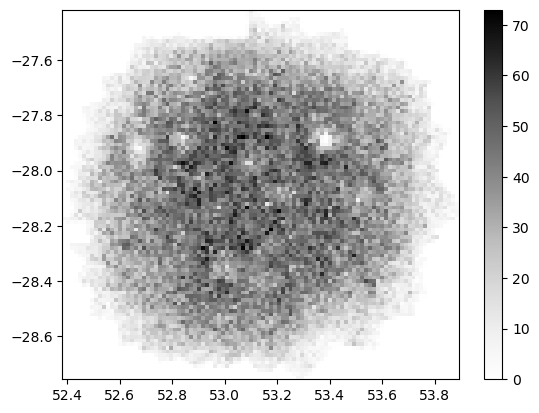

In [13]:
plt.hist2d(catalog['i_ra'], catalog['i_dec'], bins = (100,100), cmap = 'Greys')
plt.colorbar()
plt.show()

## Cross match with Euclid training set

In [25]:
import lsst.daf.butler as dafButler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.io import fits
from astropy.table import Table
from matplotlib.colors import ListedColormap, BoundaryNorm


In [26]:
catalog = pd.read_parquet('./data/galaxy_ecdfs_mag_deredden.pq')
lsst_cat = catalog

In [27]:
secured_cat = pd.read_parquet('/sdf/data/rubin/shared/pz/users/crenshaw/comcam/data/catalogs/comcam_ecdfs_crossmatched_catalog_20250618.parquet')


In [29]:
cat1_c = SkyCoord(ra=np.array(lsst_cat['i_ra'])*u.degree, dec=np.array(lsst_cat['i_dec'])*u.degree)
cat2_c = SkyCoord(ra=np.array(secured_cat['RA'])*u.degree, dec=np.array(secured_cat['DEC'])*u.degree)
# cat2_c = SkyCoord(ra=np.array(specz_table['RA'])*u.degree, dec=np.array(specz_table['DEC'])*u.degree)
idx , d2d , d3d = cat1_c.match_to_catalog_sky(cat2_c)

MIN_RADIUS = 0.6*u.arcsec
sepcheck = d2d<MIN_RADIUS

lsst_cat['match_flag'] = sepcheck
lsst_cat['redshift'] = np.array(secured_cat['redshift'])[idx]
lsst_cat['ObjectName'] = np.array(secured_cat['source'])[idx]

lsst_cat_matched = lsst_cat[lsst_cat['match_flag'] == True]
lsst_cat_matched_sf = shuffle(lsst_cat_matched)
lsst_cat_matched_sf.to_parquet('data/specz_euclid_alltypes.pq')

In [31]:
lsst_cat_matched.keys()

Index(['i_ra', 'i_dec', 'refExtendedness', 'u_cModelFlux', 'u_cModelFluxErr',
       'g_cModelFlux', 'g_cModelFluxErr', 'r_cModelFlux', 'r_cModelFluxErr',
       'i_cModelFlux',
       ...
       'i_kronMag', 'i_kronMagErr', 'z_kronMag', 'z_kronMagErr', 'y_kronMag',
       'y_kronMagErr', 'ebv', 'match_flag', 'redshift', 'ObjectName'],
      dtype='object', length=151)

Text(0.5, 0, 'Mag (gaap1p0)')

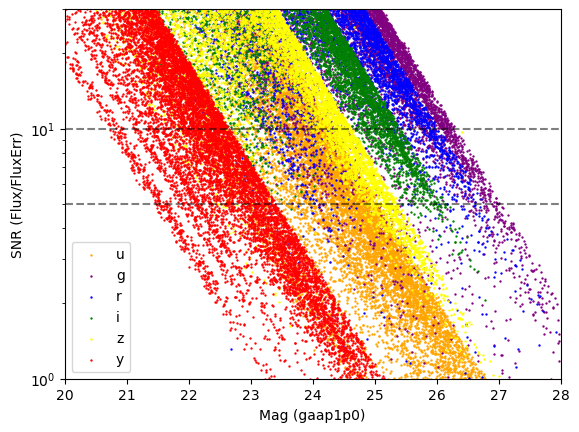

In [56]:

colors = ['orange', 'purple', 'blue', 'green', 'yellow' , 'red']
for i, band in enumerate("ugrizy"):
    plt.scatter(lsst_cat_matched[f'{band}_gaap1p0Mag'], lsst_cat_matched[f'{band}_gaap1p0Flux']/lsst_cat_matched[f'{band}_gaap1p0FluxErr'], s = 0.5, label = f'{band}', color = colors[i])
    
plt.plot([-1,100], [5,5], '--', color = 'black', alpha = 0.5)
plt.plot([-1,100], [10,10], '--', color = 'black', alpha = 0.5)

plt.yscale('log')
plt.ylim(1, 30)
plt.xlim(20, 28)
plt.legend()
plt.ylabel('SNR (Flux/FluxErr)')
plt.xlabel('Mag (gaap1p0)')
    

In [30]:
len(lsst_cat_matched_sf)

15172

Text(0, 0.5, '')

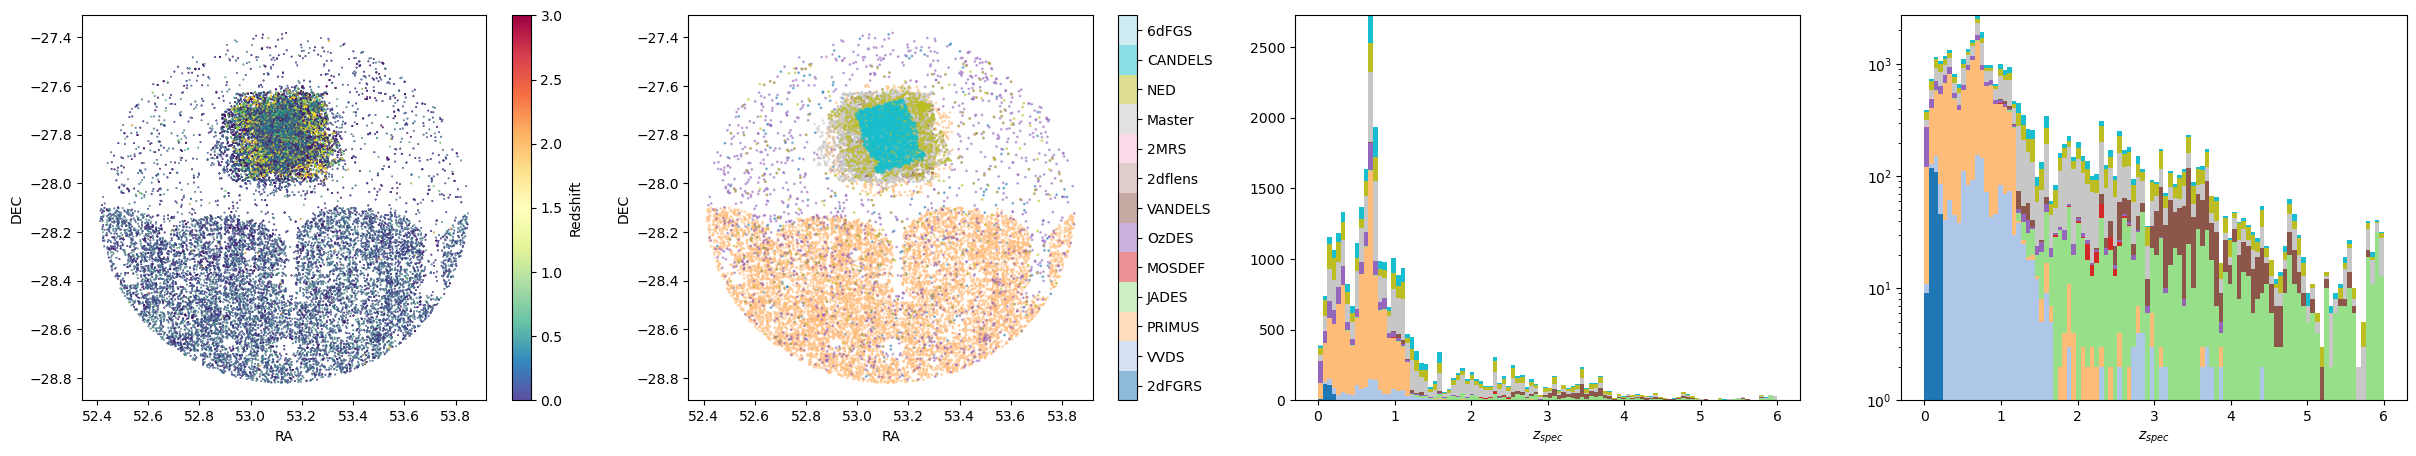

In [13]:
fig, axes = plt.subplots(1,4,figsize = (30,5))
sc = axes[0].scatter(
    secured_cat['RA'],secured_cat['DEC'],
    c =  secured_cat['redshift'], s = 0.1, vmax =3, cmap = 'Spectral_r'
)
# plt.scatter(lsst_cat_matched['i_ra'],lsst_cat_matched['i_dec'], c =  lsst_cat_matched['redshift'], s = 0.1, vmax =3 )

cbar = plt.colorbar(
    sc,
    ticks=np.arange(0, 3.5, 0.5),label = 'Redshift'
)
# cbar.ax.set_xticklabels(list(np.arange(0, 3, 0.5)) + [">3.0"])

sc = axes[0].scatter(
    secured_cat['RA'],secured_cat['DEC'],
    c =  secured_cat['redshift'], s = 0.1, vmax =3
)

axes[0].set_xlabel(r'RA')
axes[0].set_ylabel(r'DEC')


unique_types = secured_cat['source'].unique()
n_types = len(unique_types)

type_to_index = {t: i for i, t in enumerate(unique_types)}
secured_cat['type_index'] = secured_cat['source'].map(type_to_index)
cmap = plt.get_cmap('tab20', n_types)
sc = axes[1].scatter(secured_cat['RA'], secured_cat['DEC'], c=secured_cat['type_index'], cmap=cmap, s=1 ,alpha = 0.5)
# Custom colorbar with labels
cbar = plt.colorbar(sc, ticks=np.arange(n_types), boundaries=np.arange(-0.5, n_types + 0.5, 1))
cbar.ax.set_yticklabels(unique_types)
# cbar.set_label('Catalog Type')

axes[1].set_xlabel(r'RA')
axes[1].set_ylabel(r'DEC')

matched_spec = secured_cat.query("redshift > 0")
matched_spec.pivot(columns="type_index").redshift.plot.hist(
    stacked=True,
    bins=100,
    range=(0, 6),
    ax=axes[2], 
    cmap=cmap,
    legend=False
)
axes[2].set_xlabel(r'$z_{spec}$')
axes[2].set_ylabel(r'')



matched_spec = secured_cat.query("redshift > 0")
matched_spec.pivot(columns="type_index").redshift.plot.hist(
    stacked=True,
    bins=100,
    range=(0, 6),
    ax=axes[3], 
    cmap=cmap,
    legend=False
)
axes[3].set_yscale('log')
axes[3].set_xlabel(r'$z_{spec}$')
axes[3].set_ylabel(r'')



# plt.savefig('./plots/training_set_info.png', dpi = 300)

In [11]:
lsst_cat_matched

,i_ra,i_dec,refExtendedness,u_cModelFlux,u_cModelFluxErr,g_cModelFlux,g_cModelFluxErr,r_cModelFlux,r_cModelFluxErr,i_cModelFlux,...,i_kronMag,i_kronMagErr,z_kronMag,z_kronMagErr,y_kronMag,y_kronMagErr,ebv,match_flag,redshift,ObjectName
9,53.659581,-28.256695,1.0,422.229065,131.693390,2314.201904,25.520512,9399.251953,32.944294,15954.106445,...,20.821145,0.007331,20.562062,0.012480,20.300989,0.093187,0.008759,True,0.341701,PRIMUS
21,53.795050,-28.251927,1.0,401.645081,285.935699,927.911682,65.251099,1438.120728,175.476334,1697.574707,...,22.904624,0.276450,NaN,NaN,21.747422,0.447413,0.008808,True,1.046268,PRIMUS
55,53.785660,-28.235030,1.0,-380.525879,237.016922,155.064346,50.353088,890.319214,112.314796,2830.737793,...,22.834393,0.133481,21.902961,0.131719,21.468426,0.229110,0.008690,True,0.979712,PRIMUS
58,53.778215,-28.234423,1.0,1636.007690,361.718750,1236.836914,59.098228,1815.617676,126.468163,3729.858887,...,22.050644,0.159602,22.188839,0.135844,21.612362,0.616377,0.008627,True,1.063920,PRIMUS
91,53.790036,-28.219288,1.0,462.964294,356.810577,1162.428101,52.892624,2439.327393,103.527328,3596.834717,...,22.482178,0.078117,22.714184,0.170082,21.328221,0.456163,0.008729,True,0.593079,PRIMUS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27013,52.454761,-28.270916,1.0,NaN,NaN,2449.609131,137.500107,NaN,NaN,7896.384277,...,21.601985,0.043208,21.353043,0.081544,NaN,NaN,0.008297,True,0.332048,PRIMUS
27017,52.446584,-28.269292,1.0,NaN,NaN,70860.546875,343.334381,NaN,NaN,319103.906250,...,17.861037,0.002654,17.640569,0.005232,NaN,NaN,0.008202,True,0.263060,OzDES
27023,52.468844,-28.267638,1.0,11469.309570,660.264221,20010.777344,158.126724,35243.472656,133.062683,37838.562500,...,19.867588,0.009377,19.638320,0.012510,NaN,NaN,0.008373,True,0.331809,PRIMUS
27033,52.493272,-28.264966,1.0,265.378815,537.463745,1597.974365,80.188835,3311.893555,83.470581,4764.948242,...,21.856021,0.088495,22.141550,0.116281,20.676311,0.279276,0.008462,True,0.503013,PRIMUS


In [47]:
lsst_cat_matched_nonan = lsst_cat_matched.dropna()
lsst_cat_matched_nonan.to_parquet('data/specz_euclid_alltypes_nonan.pq')

In [63]:
lsst_cat_matched_sf_train = lsst_cat_matched_sf[:11000]
lsst_cat_matched_sf_test = lsst_cat_matched_sf[11000:]


save_hdf5(lsst_cat_matched_sf_train_nonan,'./data/lsst_cat_matched_nonan_train.hdf5' )
save_hdf5(lsst_cat_matched_sf_test_nonan,'./data/lsst_cat_matched_nonan_test.hdf5' )

lsst_cat_matched_sf_train_nonan = lsst_cat_matched_sf_train.dropna()
lsst_cat_matched_sf_test_nonan = lsst_cat_matched_sf_test.dropna()

print(len(lsst_cat_matched_sf_train_nonan), len(lsst_cat_matched_sf_test_nonan))

lsst_cat_matched_sf_train_fillnan = fill_nan_with_maglim(lsst_cat_matched_sf_train, mag_lim_dict)
lsst_cat_matched_sf_test_fillnan = fill_nan_with_maglim(lsst_cat_matched_sf_test, mag_lim_dict)

print(len(lsst_cat_matched_sf_train_fillnan), len(lsst_cat_matched_sf_test_fillnan))

save_hdf5(lsst_cat_matched_sf_train_fillnan,'./data/lsst_cat_matched_fillnan_train.hdf5' )
save_hdf5(lsst_cat_matched_sf_test_fillnan,'./data/lsst_cat_matched_fillnan_test.hdf5' )



Warning.  Failed to convert column No conversion path for dtype: dtype('<U7')
Warning.  Failed to convert column No conversion path for dtype: dtype('<U7')
6997 2675
11000 4172
Warning.  Failed to convert column No conversion path for dtype: dtype('<U7')
Warning.  Failed to convert column No conversion path for dtype: dtype('<U7')


/tmp/ipykernel_2280/1095087514.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].fillna(maglim)


In [30]:
len(lsst_cat_matched_nonan_sf)

9672

In [31]:
# lsst_cat_matched_nonan_sf[:7000].to_parquet('./data/lsst_cat_matched_nonan_train.pq')
# lsst_cat_matched_nonan_sf[7000:].to_parquet('./data/lsst_cat_matched_nonan_test.pq')

In [32]:
# save_hdf5(lsst_cat_matched_nonan_sf[:7000],'./data/lsst_cat_matched_nonan_train.hdf5' )
# save_hdf5(lsst_cat_matched_nonan_sf[7000:],'./data/lsst_cat_matched_nonan_test.hdf5' )

Warning.  Failed to convert column No conversion path for dtype: dtype('<U7')
Warning.  Failed to convert column No conversion path for dtype: dtype('<U7')


In [34]:
# lsst_cat_matched_sf = shuffle(lsst_cat_matched)
# len(lsst_cat_matched_sf)
# lsst_cat_matched_sf[:12000].to_parquet('./data/lsst_cat_matched_train.pq')
# lsst_cat_matched_sf[12000:].to_parquet('./data/lsst_cat_matched_test.pq')


In [35]:
# save_hdf5(lsst_cat_matched_sf[:12000],'./data/lsst_cat_matched_yesnan_train.hdf5' )
# save_hdf5(lsst_cat_matched_sf[12000:],'./data/lsst_cat_matched_yesnan_test.hdf5' )

Warning.  Failed to convert column No conversion path for dtype: dtype('<U7')
Warning.  Failed to convert column No conversion path for dtype: dtype('<U7')


# Fill NaN in the yesnan catalog by 1-sigma values

In [14]:
mag_lim_dict = {'cModelMag': {'u': 26.70024166107178,
   'g': 28.76073303222656,
   'r': 28.03392791748047,
   'i': np.nan,
   'z': 26.958034896850585,
   'y': 25.159564971923828},
  'gaap1p0Mag': {'u': 26.768558502197266,
   'g': 28.705883026123047,
   'r': 27.911192321777342,
   'i': 27.451274871826172,
   'z': 26.990221405029295,
   'y': 25.11299362182617},
  'gaap3p0Mag': {'u': 25.866476821899415,
   'g': 27.752315711975097,
   'r': 27.465567588806152,
   'i': 26.82789726257324,
   'z': 26.054798316955566,
   'y': 24.19272804260254},
  'kronMag': {'u': 25.872504425048827,
   'g': 27.904474639892577,
   'r': 27.11983299255371,
   'i': 26.09547233581543,
   'z': 26.26594696044922,
   'y': 24.362361907958984},
  'psfMag': {'u': 26.83486557006836,
   'g': 28.867864990234374,
   'r': 28.197796249389647,
   'i': np.nan,
   'z': 27.124261093139648,
   'y': 25.293622970581055},
  'sersicMag': {'u': 26.610262870788574,
   'g': 28.66030979156494,
   'r': 27.46578025817871,
   'i': 25.13613090515137,
   'z': 26.714927673339844,
   'y': 25.066210746765137}}

In [60]:
import numpy as np
import pandas as pd

def fill_nan_with_maglim(df, mag_lim_dict):
    for flux_type, band_dict in mag_lim_dict.items():
        for band, maglim in band_dict.items():
            if np.isfinite(maglim):
                col = f"{band}_{flux_type}"
                if col in df.columns:
                    df[col] = df[col].fillna(maglim)
    return df


In [26]:
lsst_cat_matched_fillnan = fill_nan_with_maglim(lsst_cat_matched, mag_lim_dict)

u_cModelMag
g_cModelMag
r_cModelMag
z_cModelMag
y_cModelMag
u_gaap1p0Mag
g_gaap1p0Mag
r_gaap1p0Mag
i_gaap1p0Mag
z_gaap1p0Mag
y_gaap1p0Mag
u_gaap3p0Mag
g_gaap3p0Mag
r_gaap3p0Mag
i_gaap3p0Mag
z_gaap3p0Mag
y_gaap3p0Mag
u_kronMag
g_kronMag
r_kronMag
i_kronMag
z_kronMag
y_kronMag
u_psfMag
g_psfMag
r_psfMag
z_psfMag
y_psfMag
u_sersicMag
g_sersicMag
r_sersicMag
i_sersicMag
z_sersicMag
y_sersicMag


/tmp/ipykernel_2280/4171942627.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].fillna(maglim)


In [24]:
lsst_cat_matched_fillnan

,i_ra,i_dec,refExtendedness,u_cModelFlux,u_cModelFluxErr,g_cModelFlux,g_cModelFluxErr,r_cModelFlux,r_cModelFluxErr,i_cModelFlux,...,i_kronMag,i_kronMagErr,z_kronMag,z_kronMagErr,y_kronMag,y_kronMagErr,ebv,match_flag,redshift,ObjectName
9,53.659581,-28.256695,1.0,422.229065,131.693390,2314.201904,25.520512,9399.251953,32.944294,15954.106445,...,20.821145,0.007331,20.562062,0.012480,20.300989,0.093187,0.008759,True,0.341701,PRIMUS
21,53.795050,-28.251927,1.0,401.645081,285.935699,927.911682,65.251099,1438.120728,175.476334,1697.574707,...,22.904624,0.276450,26.265947,NaN,21.747422,0.447413,0.008808,True,1.046268,PRIMUS
55,53.785660,-28.235030,1.0,-380.525879,237.016922,155.064346,50.353088,890.319214,112.314796,2830.737793,...,22.834393,0.133481,21.902961,0.131719,21.468426,0.229110,0.008690,True,0.979712,PRIMUS
58,53.778215,-28.234423,1.0,1636.007690,361.718750,1236.836914,59.098228,1815.617676,126.468163,3729.858887,...,22.050644,0.159602,22.188839,0.135844,21.612362,0.616377,0.008627,True,1.063920,PRIMUS
91,53.790036,-28.219288,1.0,462.964294,356.810577,1162.428101,52.892624,2439.327393,103.527328,3596.834717,...,22.482178,0.078117,22.714184,0.170082,21.328221,0.456163,0.008729,True,0.593079,PRIMUS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27013,52.454761,-28.270916,1.0,NaN,NaN,2449.609131,137.500107,NaN,NaN,7896.384277,...,21.601985,0.043208,21.353043,0.081544,24.362362,NaN,0.008297,True,0.332048,PRIMUS
27017,52.446584,-28.269292,1.0,NaN,NaN,70860.546875,343.334381,NaN,NaN,319103.906250,...,17.861037,0.002654,17.640569,0.005232,24.362362,NaN,0.008202,True,0.263060,OzDES
27023,52.468844,-28.267638,1.0,11469.309570,660.264221,20010.777344,158.126724,35243.472656,133.062683,37838.562500,...,19.867588,0.009377,19.638320,0.012510,24.362362,NaN,0.008373,True,0.331809,PRIMUS
27033,52.493272,-28.264966,1.0,265.378815,537.463745,1597.974365,80.188835,3311.893555,83.470581,4764.948242,...,21.856021,0.088495,22.141550,0.116281,20.676311,0.279276,0.008462,True,0.503013,PRIMUS


In [40]:
lsst_cat_matched_fillnan_sf = shuffle(lsst_cat_matched_fillnan)
len(lsst_cat_matched_fillnan_sf)
save_hdf5(lsst_cat_matched_fillnan_sf[:12000],'./data/lsst_cat_matched_fillnan_train.hdf5' )
save_hdf5(lsst_cat_matched_fillnan_sf[12000:],'./data/lsst_cat_matched_fillnan_test.hdf5' )

Warning.  Failed to convert column No conversion path for dtype: dtype('<U7')
Warning.  Failed to convert column No conversion path for dtype: dtype('<U7')


## Conver J-F's parquet to training and test set (Jun 24th)

In [73]:
def save_hdf5(df, filename):
    np_dict = tables_io.convert(df, tables_io.types.NUMPY_DICT)
    tables_io.write(np_dict, filename )

# Get J-F's latest cross matched catalog
jf_pq = pd.read_parquet('/sdf/data/rubin/shared/pz/users/crenshaw/comcam/data/catalogs/comcam_ecdfs_crossmatched_catalog_20250618.parquet')
# Select objects with confidence >= 0.95
jf_pq_95  = jf_pq[jf_pq['confidence']>=0.90]
# Drop NaNs in gaap1p0 columns
jf_pq_95_nonan = jf_pq_95.dropna(subset=[col for col in jf_pq_95.columns if 'gaap1p0' in col])

# 80% of the objects as the training set
n_train = int(len(jf_pq_95_nonan)*0.8)
# Reserve 20% of the objects as the testing set
n_test = len(jf_pq_95_nonan) - n_train

print(n_train, n_test)
# shuffle
jf_pq_95_nonan_sf = shuffle(jf_pq_95_nonan, random_state=20241024) # comcam first light date
jf_pq_95_nonan_sf_train = jf_pq_95_nonan_sf[:n_train]
jf_pq_95_nonan_sf_test = jf_pq_95_nonan_sf[n_train:]

# save as HDF5
# save_hdf5(jf_pq_95_nonan_sf_train, '/sdf/data/rubin/shared/pz/data/train/dp1_matched_v2_train.hdf5')
# save_hdf5(jf_pq_95_nonan_sf_test, '/sdf/data/rubin/shared/pz/data/test/dp1_matched_v2_test.hdf5')


save_hdf5(jf_pq_95_nonan_sf_train, './data/dp1_matched_v3_train.hdf5')
save_hdf5(jf_pq_95_nonan_sf_test, './data/dp1_matched_v3_test.hdf5')



13328 3333
Warning.  Failed to convert column No conversion path for dtype: dtype('<U1')
Warning.  Failed to convert column No conversion path for dtype: dtype('<U1')
Warning.  Failed to convert column No conversion path for dtype: dtype('<U14')
Warning.  Failed to convert column No conversion path for dtype: dtype('<U1')
Warning.  Failed to convert column No conversion path for dtype: dtype('<U1')
Warning.  Failed to convert column No conversion path for dtype: dtype('<U14')


In [15]:
len(jf_pq_95_nonan)

12760

In [18]:
jf_pq.keys()

Index(['coord_ra', 'coord_dec', 'refExtendedness', 'refBand', 'u_cModelMag',
       'u_cModelMagErr', 'g_cModelMag', 'g_cModelMagErr', 'r_cModelMag',
       'r_cModelMagErr', 'i_cModelMag', 'i_cModelMagErr', 'z_cModelMag',
       'z_cModelMagErr', 'y_cModelMag', 'y_cModelMagErr', 'u_sersicMag',
       'u_sersicMagErr', 'g_sersicMag', 'g_sersicMagErr', 'r_sersicMag',
       'r_sersicMagErr', 'i_sersicMag', 'i_sersicMagErr', 'z_sersicMag',
       'z_sersicMagErr', 'y_sersicMag', 'y_sersicMagErr', 'u_gaap1p0Mag',
       'u_gaap1p0MagErr', 'g_gaap1p0Mag', 'g_gaap1p0MagErr', 'r_gaap1p0Mag',
       'r_gaap1p0MagErr', 'i_gaap1p0Mag', 'i_gaap1p0MagErr', 'z_gaap1p0Mag',
       'z_gaap1p0MagErr', 'y_gaap1p0Mag', 'y_gaap1p0MagErr', 'u_gaap3p0Mag',
       'u_gaap3p0MagErr', 'g_gaap3p0Mag', 'g_gaap3p0MagErr', 'r_gaap3p0Mag',
       'r_gaap3p0MagErr', 'i_gaap3p0Mag', 'i_gaap3p0MagErr', 'z_gaap3p0Mag',
       'z_gaap3p0MagErr', 'y_gaap3p0Mag', 'y_gaap3p0MagErr', 'u_psfMag',
       'u_psfMagErr', 'g_p

In [64]:
len(jf_pq),np.sum(jf_pq['type']=='s'), np.sum(jf_pq['type']=='p'), np.sum(jf_pq['type']=='g'), np.unique(jf_pq['type']), 

(277886,
 np.int64(7699),
 np.int64(9301),
 np.int64(5622),
 array(['', 'g', 'p', 's'], dtype=object))

(array([3.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.500e+01,
        0.000e+00, 1.127e+03, 0.000e+00, 6.544e+03]),
 array([0.8 , 0.82, 0.84, 0.86, 0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <BarContainer object of 10 artists>)

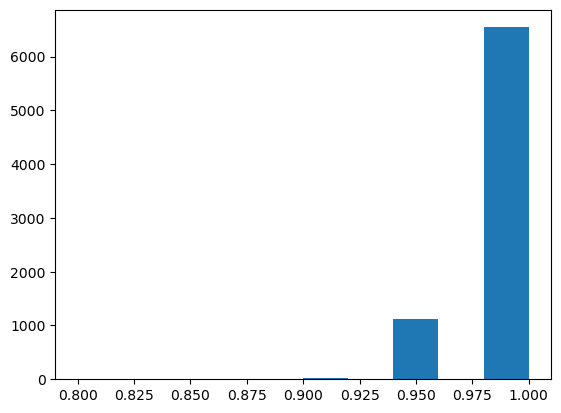

In [70]:
plt.hist(jf_pq[jf_pq['type']=='s']['confidence'])

## Train test gold (make train test directly from JF's cross match)

In [43]:
def save_hdf5(df, filename):
    np_dict = tables_io.convert(df, tables_io.types.NUMPY_DICT)
    tables_io.write(np_dict, filename )

# Get J-F's latest cross matched catalog
jf_pq = pd.read_parquet('/sdf/data/rubin/shared/pz/users/crenshaw/comcam/data/catalogs/comcam_ecdfs_crossmatched_catalog_20250618.parquet')
# Select objects with confidence >= 0.95
jf_pq_90  = jf_pq[jf_pq['confidence']>=0.90]
# Drop NaNs in gaap1p0 columns
jf_pq_90_nonan = jf_pq_90.dropna(subset=[col for col in jf_pq_90.columns if 'gaap1p0' in col])

jf_pq_90_nonan_high_snr = jf_pq_90_nonan[jf_pq_90_nonan['snr_i_cModel']>20]

# 80% of the objects as the training set
n_train = int(len(jf_pq_90_nonan_high_snr)*0.7)
# Reserve 20% of the objects as the testing set
n_test = len(jf_pq_90_nonan_high_snr) - n_train

print(n_train, n_test)
# shuffle
jf_pq_90_nonan_sf = shuffle(jf_pq_90_nonan_high_snr, random_state=20241024) # comcam first light date
jf_pq_90_nonan_sf_train = jf_pq_90_nonan_sf[:n_train]
jf_pq_90_nonan_sf_test = jf_pq_90_nonan_sf[n_train:]

# save as HDF5
# save_hdf5(jf_pq_90_nonan_sf_train, '/sdf/data/rubin/shared/pz/data/train/dp1_matched_v2_train.hdf5')
# save_hdf5(jf_pq_90_nonan_sf_test, '/sdf/data/rubin/shared/pz/data/test/dp1_matched_v2_test.hdf5')

# v3 = p+s+g, snr = 10, confidence > 0.9
# v4 = p+s+g, snr = 20, confidence > 0.9
# v5 = p+s+g, snr = 20, confidence > 0.95



# save_hdf5(jf_pq_90_nonan_sf_train, './data/dp1_matched_v5_train.hdf5')
# save_hdf5(jf_pq_90_nonan_sf_test, './data/dp1_matched_v5_test.hdf5')



6778 2905


In [39]:
# jf_pq_90_nonan_high_snr

(array([322., 430., 439., 538., 522., 678., 741., 729., 786., 758., 673.,
        445., 193.,   7.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([23. , 23.2, 23.4, 23.6, 23.8, 24. , 24.2, 24.4, 24.6, 24.8, 25. ,
        25.2, 25.4, 25.6, 25.8, 26. , 26.2, 26.4, 26.6, 26.8, 27. ]),
 <BarContainer object of 20 artists>)

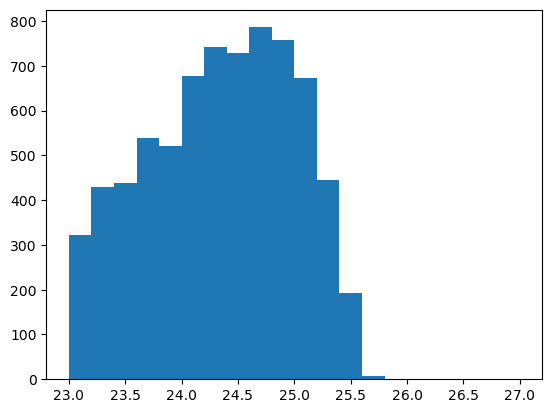

In [32]:
plt.hist(jf_pq_90_nonan_high_snr['i_cModelMag'], range = (23,27), bins = 20)

In [19]:
jf_pq_90_nonan_high_snr.keys()

Index(['objectId', 'coord_ra', 'coord_dec', 'refExtendedness', 'refBand',
       'u_cModelMag', 'u_cModelMagErr', 'g_cModelMag', 'g_cModelMagErr',
       'r_cModelMag', 'r_cModelMagErr', 'i_cModelMag', 'i_cModelMagErr',
       'z_cModelMag', 'z_cModelMagErr', 'y_cModelMag', 'y_cModelMagErr',
       'u_sersicMag', 'u_sersicMagErr', 'g_sersicMag', 'g_sersicMagErr',
       'r_sersicMag', 'r_sersicMagErr', 'i_sersicMag', 'i_sersicMagErr',
       'z_sersicMag', 'z_sersicMagErr', 'y_sersicMag', 'y_sersicMagErr',
       'u_gaap1p0Mag', 'u_gaap1p0MagErr', 'g_gaap1p0Mag', 'g_gaap1p0MagErr',
       'r_gaap1p0Mag', 'r_gaap1p0MagErr', 'i_gaap1p0Mag', 'i_gaap1p0MagErr',
       'z_gaap1p0Mag', 'z_gaap1p0MagErr', 'y_gaap1p0Mag', 'y_gaap1p0MagErr',
       'u_gaap3p0Mag', 'u_gaap3p0MagErr', 'g_gaap3p0Mag', 'g_gaap3p0MagErr',
       'r_gaap3p0Mag', 'r_gaap3p0MagErr', 'i_gaap3p0Mag', 'i_gaap3p0MagErr',
       'z_gaap3p0Mag', 'z_gaap3p0MagErr', 'y_gaap3p0Mag', 'y_gaap3p0MagErr',
       'u_psfMag', 'u_psfM